In [1]:
!pip install opencv-python numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\juanc\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
# Importar librerías
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Crear carpeta de salida si no existe
output_dir = 'Resultados'
os.makedirs(output_dir, exist_ok=True)

# Función para mostrar y guardar imágenes
def mostrar_y_guardar(imagen, titulo='', nombre_archivo=None, cmap='gray'):
    if nombre_archivo:
        ruta_salida = os.path.join(output_dir, nombre_archivo)
        cv2.imwrite(ruta_salida, imagen)
        print(f"Guardada: {ruta_salida}")
    plt.figure(figsize=(6,6))
    plt.title(titulo)
    plt.axis('off')
    plt.imshow(imagen, cmap=cmap)
    plt.show()

# 1. Carga y conversión a escala de grises

Guardada: Resultados\original.png


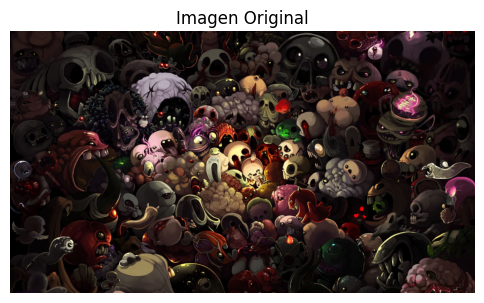

Guardada: Resultados\gris_manual.png


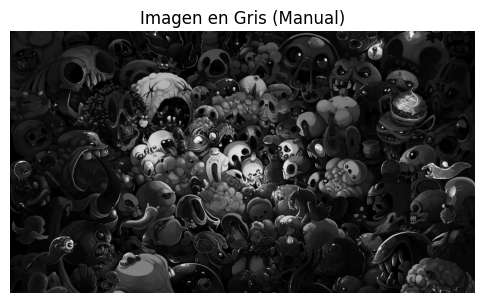

In [3]:
ruta = 'Datos/TBOI.jpg'
en_color = cv2.imread(ruta)
en_color_rgb = cv2.cvtColor(en_color, cv2.COLOR_BGR2RGB)
mostrar_y_guardar(en_color_rgb, 'Imagen Original', 'original.png', cmap=None)

def a_grises_manual(img_rgb):
    R, G, B = img_rgb[:,:,0], img_rgb[:,:,1], img_rgb[:,:,2]
    gris = ((R.astype(float) + G.astype(float) + B.astype(float)) / 3.0)
    return gris.astype(np.uint8)

gris = a_grises_manual(en_color_rgb)
mostrar_y_guardar(gris, 'Imagen en Gris (Manual)', 'gris_manual.png')

# 2. Convolución 2D manual con NumPy

In [4]:
def convolucion2d(imagen, kernel):
    h, w = imagen.shape
    kh, kw = kernel.shape
    pad_h, pad_w = kh//2, kw//2
    img_pad = np.pad(imagen, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)
    salida = np.zeros((h,w), dtype=float)
    ek = np.flipud(np.fliplr(kernel))  # kernel invertido
    for i in range(h):
        for j in range(w):
            region = img_pad[i:i+kh, j:j+kw]
            salida[i,j] = np.sum(region * ek)
    return salida

# 3. Definición de kernels personalizados

In [5]:
kernel_sharpen = np.array([[ 0, -1,  0],
                           [-1,  5, -1],
                           [ 0, -1,  0]])
kernel_blur    = np.ones((3,3), dtype=float) / 9.0
kernel_sobel_x = np.array([[-1, 0, 1],
                           [-2, 0, 2],
                           [-1, 0, 1]])
kernel_sobel_y = np.array([[-1, -2, -1],
                           [ 0,  0,  0],
                           [ 1,  2,  1]])

# 4. Aplicación de kernels manual y visualización

Guardada: Resultados\manual_sharpen.png


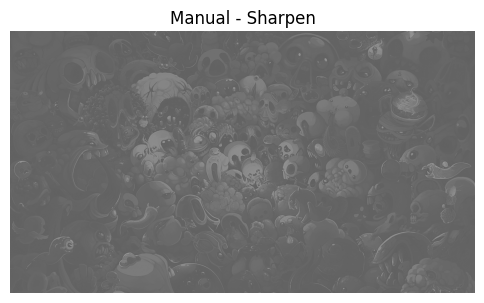

Guardada: Resultados\manual_blur.png


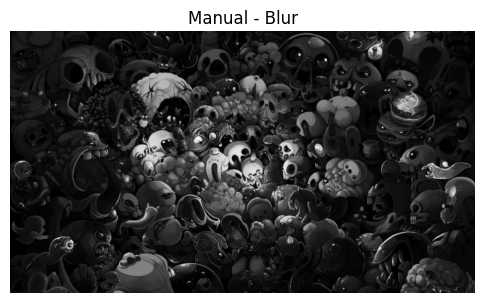

Guardada: Resultados\manual_sobelmag.png


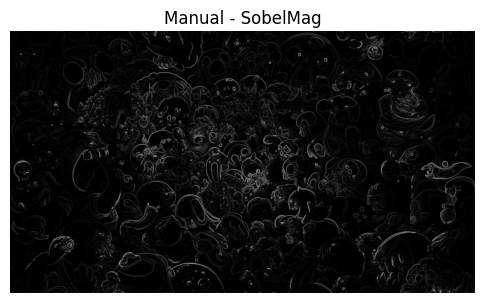

Guardada: Resultados\manual_corners.png


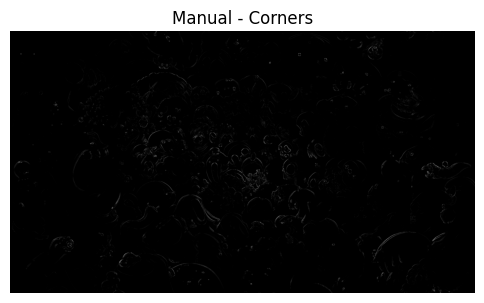

In [6]:
# Preprocesar
gris_f = gris.astype(float)

# Función auxiliar de normalización
def norm_uint8(img):
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Aplicar y guardar resultados manuales
res_manual = {}
counters = 0
for name, kernel in [('Sharpen', kernel_sharpen),
                     ('Blur',    kernel_blur),
                     ('SobelMag', None),
                     ('Corners', None)]:
    if kernel is not None:
        conv = convolucion2d(gris_f, kernel)
    elif name == 'SobelMag':
        gx = convolucion2d(gris_f, kernel_sobel_x)
        gy = convolucion2d(gris_f, kernel_sobel_y)
        conv = np.hypot(gx, gy)
    else:  # Corners
        gx = convolucion2d(gris_f, kernel_sobel_x)
        gy = convolucion2d(gris_f, kernel_sobel_y)
        conv = np.abs(gx * gy)
    img_uint8 = norm_uint8(conv)
    filename = f"manual_{name.lower()}.png"
    mostrar_y_guardar(img_uint8, f'Manual - {name}', filename)
    res_manual[name] = img_uint8
    counters += 1

# 5. Comparación con OpenCV `cv2.filter2D()`

Guardada: Resultados\opencv_sharpen.png


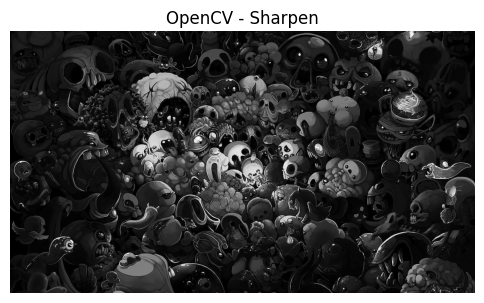

Guardada: Resultados\opencv_blur.png


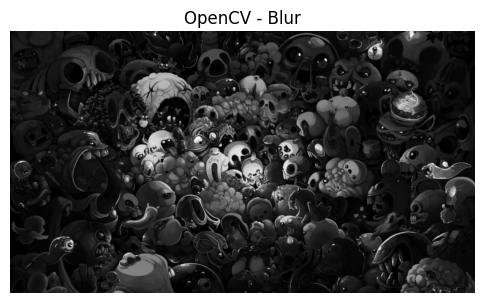

Guardada: Resultados\opencv_sobelx.png


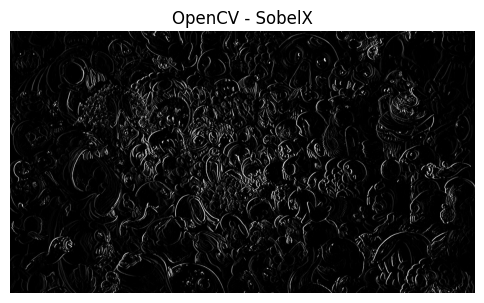

Guardada: Resultados\opencv_sobely.png


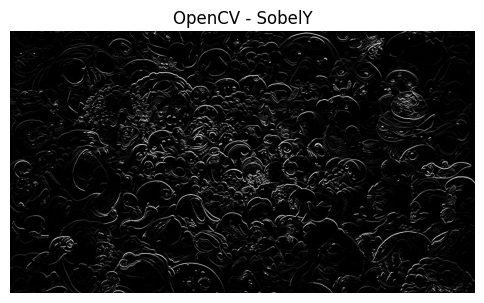

In [7]:
# Función para aplicar y guardar filter2D
def aplic_opencv(imagen, kernel, nombre):
    res = cv2.filter2D(imagen, ddepth=-1, kernel=kernel)
    filename = f"opencv_{nombre.lower()}.png"
    mostrar_y_guardar(res, f'OpenCV - {nombre}', filename)
    return res

res_opencv = {}
for name, kernel in [('Sharpen', kernel_sharpen),
                     ('Blur',    kernel_blur),
                     ('SobelX',  kernel_sobel_x),
                     ('SobelY',  kernel_sobel_y)]:
    res_opencv[name] = aplic_opencv(gris, kernel, name)

# 6. Interfaz interactiva con sliders (cv2.createTrackbar)

In [ ]:
slider_names = [
    'Top-Left', 'Top-Center', 'Top-Right',
    'Mid-Left', 'Mid-Center', 'Mid-Right',
    'Bot-Left', 'Bot-Center', 'Bot-Right'
]

def nothing(x):
    pass

window_name = 'Interactive Filter'
cv2.namedWindow(window_name)
# Crear trackbars con nombres descriptivos
def create_sliders():
    for idx, name in enumerate(slider_names):
        cv2.createTrackbar(name, window_name, 5, 10, nothing)

create_sliders()

while True:
    # Leer valores y construir kernel 3x3
    values = [cv2.getTrackbarPos(name, window_name) - 5 for name in slider_names]
    kernel = np.array(values, dtype=float).reshape((3,3))
    # Aplicar filtro y mostrar
    filtered = cv2.filter2D(gris, ddepth=-1, kernel=kernel)
    cv2.imshow('Original', gris)
    cv2.imshow(window_name, filtered)
    key = cv2.waitKey(1)
    if key & 0xFF == ord('s'):
        ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        fname = f"interactive_{ts}.png"
        cv2.imwrite(os.path.join(output_dir, fname), filtered)
        print(f"Guardada: {fname}")
    elif key & 0xFF == 27:
        break

cv2.destroyAllWindows()

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:2564: error: (-27:Null pointer) NULL window: 'Interactive Filter' in function 'cvGetTrackbarPos'


: 